## Use the finetuned model to infer
This notebook is to use our finetuned BERT-based model to infer which reddit community does the post in r/mushroomkingdom belong to.

In [24]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pickle
import torch
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the df dataframe
with open('data/df.pickle', 'rb') as f:
    df = pickle.load(f)

In [4]:
# Load the saved model
model = AutoModelForSequenceClassification.from_pretrained("model", num_labels=2)
model.to(device)

# Load the encoder
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

### Choose the non-empty mushroomkingdom posts.

In [5]:
# Choose the df with type = 'mushroomkingdom'
df_predict = df[df['type'] == 'mushroomkingdom']
# Choose the rows with body not in ['[deleted]', '[removed]'] and not empty
df_predict = df_predict[~df_predict['body'].isna()]
df_predict = df_predict[~df_predict['body'].isin(['[deleted]', '[removed]'])]

In [6]:
text = df_predict['body'].tolist()
predictions = []
for index, body in enumerate(text):
    try:
        encoded = tokenizer(body, padding=True, truncation=True, return_tensors="pt").to(device)
        # Get the predictions
        prediction = model(**encoded)
        prediction = prediction.logits.argmax(dim=-1).tolist()
    except:
        prediction = 0.5
    predictions.append(prediction[0])
    if index % 200 == 0:
        print(index)

df_predict['pred'] = predictions


0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400
10600
10800
11000
11200
11400
11600
11800
12000
12200
12400
12600
12800
13000
13200
13400
13600
13800
14000
14200
14400
14600
14800
15000
15200
15400
15600
15800
16000
16200
16400
16600
16800
17000
17200
17400
17600
17800
18000
18200
18400
18600
18800
19000
19200
19400
19600
19800
20000
20200
20400
20600
20800
21000
21200
21400
21600
21800
22000
22200
22400
22600
22800
23000
23200


In [7]:
pattern = r"/r/(\w+)/"
# Get the subreddit from the body
df_predict['subreddit'] = df_predict['body'].str.extract(pattern, expand=False)
# lower the subreddit
df_predict['subreddit'] = df_predict['subreddit'].str.lower()
# List the subreddit and the number of posts
df_predict['subreddit'].value_counts()

gamesale               19396
gameswap                3278
retrogameswap             22
mushroomkingdom           20
hardwareswap              10
steamgameswap              6
gameboymarketplace         4
amiiboswap                 4
gctrading                  2
giftcardexchange           2
gametrade                  2
nintendoswitchdeals        2
Name: subreddit, dtype: int64

In [8]:
#
def map_predict(comment):
    if comment['subreddit']:
        if comment['pred']==1:
            return 'gamesale'
        elif comment['pred']==0:
            return 'gameswap'
        else:
            return comment['type']
    else:
        return comment['type']

In [ ]:
with open('data/df_predict.pickle', 'wb') as f:
    pickle.dump(df_predict, f)
    # Combine df_predict and df by index
for index, row in df_predict.iterrows():
    df.loc[index, 'pred'] = row['pred']
    df.loc[index, 'subreddit'] = row['subreddit']
# Replace nan in subreddit by type
df['subreddit']=df.apply(lambda x: map_predict(x),axis=1)

<Figure size 640x480 with 0 Axes>

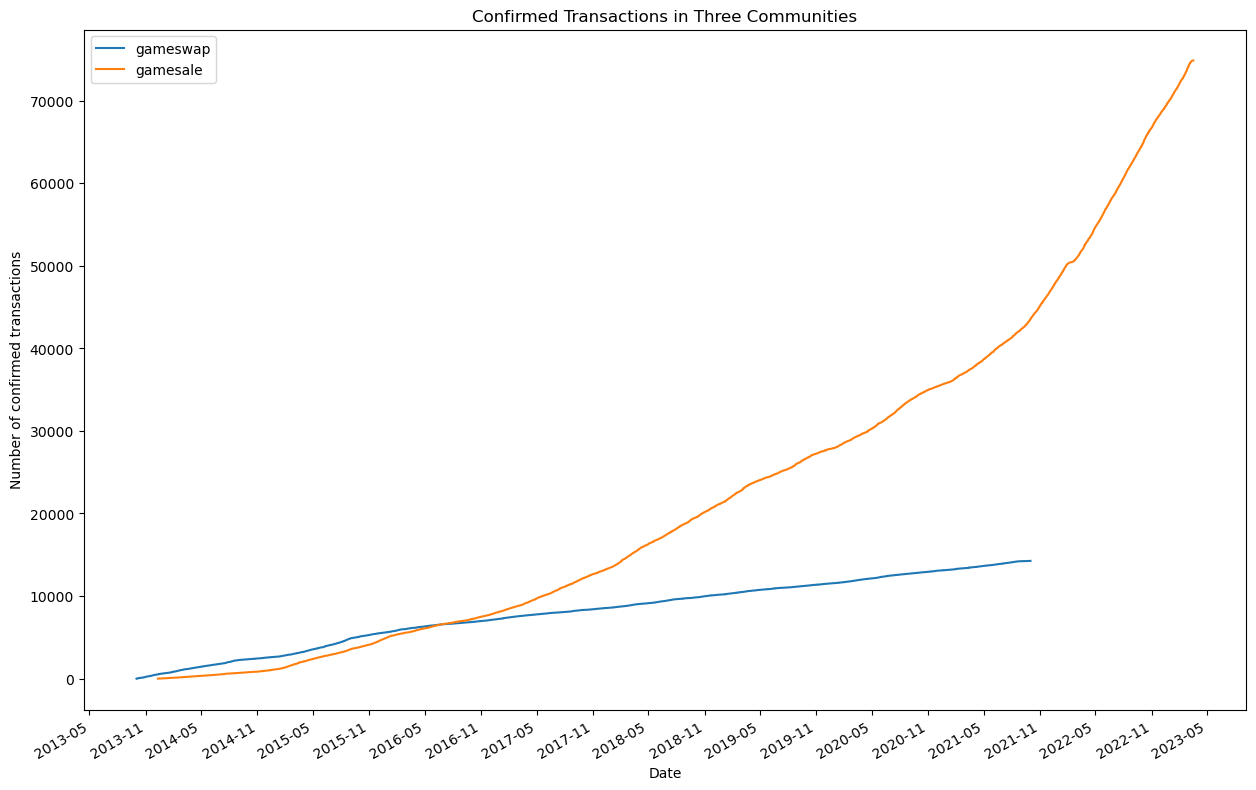

In [29]:
plt.clf()
plt.figure(figsize=(15, 10))
df[df['subreddit'] == 'gameswap'].groupby('created_utc').count()['index'].cumsum().plot()
df[df['subreddit'] == 'gamesale'].groupby('created_utc').count()['index'].cumsum().plot()
plt.xlabel('Date')
plt.ylabel('Number of confirmed transactions')
plt.title('Confirmed Transactions in Three Communities')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.legend(['gameswap', 'gamesale'])
plt.savefig('plot/confirmed_processed.png',dpi=300)
plt.show()

In [10]:
with open('data/gameswap_history.pickle','wb') as f:
    pickle.dump(df[df['subreddit']=='gameswap'],f)

In [11]:
with open('data/gamesale_history.pickle','wb') as f:
    pickle.dump(df[df['subreddit']=='gamesale'],f)

In [12]:
with open('data/mushroomkingdom_history.pickle','wb') as f:
    pickle.dump(df[df['subreddit']=='mushroomkingdom'],f)

In [13]:
df['subreddit'].value_counts()

gamesale           74864
gameswap           14262
mushroomkingdom      556
Name: subreddit, dtype: int64

In [14]:
df[df['subreddit']=='mushroomkingdom']['author'].value_counts()

[deleted]    556
Name: author, dtype: int64